# Formulating the Objective Function and The Dark Art of Weighting

The objective function expresses model-to-measurement misfit for use in the solution of an inverse problem through the *weighted squared difference between measured and simulated observations*. There is no formula for a universally "best approach" to formulate an objective function. However, the universal underlying principle is to ensure that as much information as possible is transferred to the parameters of a model, in as "safe" a way as possible (Doherty, 2015). 

What do we mean by "safe"? We mean that, in attempting to fit model outputs to measured observations, we should minimize the potential for model structural error to induce model parameters to take on values that compensate for model imperfections. When estimated parameters take on compensating roles, the potential for error in predictions may actually increase, rather than decrease, during the process of calibration (White et al. 2014). And we don't want that!

**Observation Types**

In most history matching contexts a “multicomponent” objective function is recommended. Each component of this objective function is calculated on the basis of different groups of observations or of the same group of observations processed in different ways. In a nut-shell, this means as many (useful!) types of observation as are available should be included in the parameter-estimation process. This does not **just** mean different "measurement types"! It also means teasing out components *within* a given measurement type. These "secondary" components often contain information that is otherwise lost or overshadowed. 

**Grouping** 

Using a multicomponent approach can extract as much information from an observation dataset as possible and transfer this information to estimated parameters. When constructing a PEST dataset, it is often usefull (and convenient) to group observations by type. This makes it easier to customize objective function design and track the flow of infromation from data to parameters (and subsequently to predictions). Ideally, each observation grouping should illuminate and constrain the parameter estimation related to a separate aspect of the system beiong modelled (Doherty and Hunt, 2010). For example, absolute values of heads may inform parameters that control horizontal flow patterns, whilst vertical diferences between heads in different aquifers may inform parameters that control vertical flow patterns. 

**Weighting**

A user must decide how to weight observations before estimating parameters with PEST. In some cases, it is prudent to strictly weight observations based on the inverse of the standard deviation of measurement noise. Observations with higher credibility should, without a doubt, be given more weight than those with lower credibility. However, in many history-matching contexts, model defects are just as important as noise in inducing model-to-measurement misfit as field measurements. Some types of model outputs are more affected by model imperfections than others. Notably, the effects of imperfections on model output differences (whether spatial or temporal) are frequently less than their effects on raw model outputs.

As a result, including measurement differences and corresponding model output differences in a calibration dataset can often improve a history-matching process. It can also be improved by dividing components of a measurement dataset into groups based on type and location, assigning these measurements to different observation groups, and ensuring that the contributions made by each of these groups to the original objective function are roughly the same. In the parameter estimation process, the information content of each of these groups is thus given equal weight. In other cases, accommodating the "structural" nature of model-to-measurement misfit is preferable (i.e. the model is inherently better at fitting some measurements than others). 

The PEST Book (Doherty, 2015) and the USGS published report "A Guide to Using PEST for Groundwater-Model Calibration" (Doherty et al 2010) go into detail on formulating an objective function and discuss common issues with certain data-types. 

**References and Recommended Reading:**
 - Doherty, J., (2015). Calibration and Uncertainty Analysis for Complex Environmental Models. Watermark Numerical Computing, Brisbane, Australia. ISBN: 978-0-9943786-0-6.
 - <div class="csl-entry">White, J. T., Doherty, J. E., &#38; Hughes, J. D. (2014). Quantifying the predictive consequences of model error with linear subspace analysis. <i>Water Resources Research</i>, <i>50</i>(2), 1152–1173. https://doi.org/10.1002/2013WR014767</div>
 - <div class="csl-entry">Doherty, J., &#38; Hunt, R. (2010). <i>Approaches to Highly Parameterized Inversion: A Guide to Using PEST for Groundwater-Model Calibration: U.S. Geological Survey Scientific Investigations Report 2010–5169</i>. https://doi.org/https://doi.org/10.3133/sir20105169</div>


### 1. The modified Freyberg PEST dataset

The modified Freyberg model is introduced in another tutorial notebook (see "freyberg intro to model"). The current notebook picks up following the "freyberg psfrom pest setup" notebook, in which a high-dimensional PEST dataset was constructed using `pyemu.PstFrom`. You may also wish to go through the "intro to pyemu" notebook beforehand.

We will now address observation weighting prior to history matching. 

Recall from the "freyberg pstfrom pest setup" notebook that we included several observation types in the history matching dataset:
 - head time-series
 - river flux time-series
 - temporal differences between both heads and flux time-series
 - vertical head differences

We also assigned weights to each of these types. Weights were assigned to each obsveration type based on the inverse of measurement noise. 

The next couple of cells load necessary dependencies and call a convenience function to prepare the PEST dataset folder for you. This is the same dataset that was constructed during the "freyberg pstfrom pest setup" tutorial. Simply press `shift+enter` to run the cells.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import pandas as pd
import matplotlib.pyplot as plt;

import sys
sys.path.append("..")
# import pre-prepared convenience functions
import herebedragons as hbd

In [2]:
# specify the temporary working folder
t_d = os.path.join('freyberg6_template')

In [3]:
# use the conveninece function to get the pre-preprepared PEST dataset;
# this is the same dataset consutrcted in the "pstfrom" tutorial
hbd.dir_cleancopy(org_d=os.path.join('..','..', 'models','freyberg_pstfrom_pest_setup'), 
                new_d=t_d)

Files copied from:..\..\models\freyberg_pstfrom_pest_setup
Files copied to:freyberg6_template


### 2. Run PEST once

We are going to start off by taking a look at our current objective function value and the relative contributions from the various observation groups. Recall that this is the objective function value with **initial parameter values** and observations weighted according to the **inverse of the measurement standard deviation**.

First off, we need to get PEST to run the model once so that the objective function can be calculated. Let's do that now. Start by reading the control file and checking that NOPTMAX is set to zero:

In [4]:
# we will reference the PEST control file basename quite a lot, so let's make a variable
basename = 'freyberg_mf6'

# load the contorl file
pst = pyemu.Pst(os.path.join(t_d, f'{basename}.pst'))

# check noptmax
pst.control_data.noptmax

0

You got a zero? Good, let's run PEST and then update the `Pst` residuals attribute:

In [5]:
# run pest++glm; may take a few seconds
pyemu.os_utils.run(f"pestpp-glm {basename}.pst", cwd=t_d)

In [6]:
# update the Pst residuals from the newly generated *.rei file
pst.set_res(os.path.join(t_d, f'{basename}.rei'))

OK. Lets take a look at the value of Phi (e.g. the objective function):

In [7]:
pst.phi

22079932.708007276

That's pretty high. A convenience of weighting with the inverse of the measurement uncertainty is that it is easy to know what the ideal Phi should be: it should be equal to the number of non-zero weighted observations. This of course assumes that all model-to-measurment misfit is due to *measurement* uncertainty. In practice, model error usualy plays a larger role, as we will see in other tutorials. 

Just to demonstrate what we mean, let's quickly do some math. Imagine that we have:
 - 2 observations
 - both have measured values of 1
 - with measurement standard deviation (e.g. uncertainty) of 0.25
 - therefore, their are assigned a weight of 1/0.25 = 4

So, all that we know is that the true measured values are most likely to be somewhere between 0.75 and 1.25. Therefore, the best that a modelled value should be expected to achieve is 1 +/- 0.25. 

Let's say we obtain modelled values for each of observation: 
 - 1.25
 - 0.75

 Let's calculate Phi for such a case:

In [8]:
weight = 1/0.25
# res = (weight * (meas - sim)) ^ 2
res1 = (weight * (1 - 1.25))**2
res2 = (weight * (1 - 0.75))**2
# sum the squared weighted residuals
phi = res1 + res2
phi

2.0

And there you have it, the value of Phi is equal to the number of observations. 

So! Back to Freyberg.

How many non-zero observations do we have in the dataset? Recall this number is recorded in the control file and easily acceisble through the `Pst.nnz_obs` attribute. So our current Phi (see `pst.phi`) is quite a bit higher than that. Hopefully history matching will help us bring it down.

In [9]:
pst.nnz_obs

920

### 3. Phi Components

Before we race off and start running PEST we should take a look at the components of Phi. 

The `pst.phi_components` attribute returns a dictionary of the observation group names and their contribution to the overal value of Phi. 

In [10]:
pst.phi_components

{'oname:hds_otype:lst_usecol:trgw_0_13_10': 22.548833345731033,
 'oname:hds_otype:lst_usecol:trgw_0_15_16': 9.163214088179668,
 'oname:hds_otype:lst_usecol:trgw_0_21_10': 13.674376427017872,
 'oname:hds_otype:lst_usecol:trgw_0_22_15': 6.158026555620956,
 'oname:hds_otype:lst_usecol:trgw_0_24_4': 29.251805081954917,
 'oname:hds_otype:lst_usecol:trgw_0_26_6': 30.81801233159611,
 'oname:hds_otype:lst_usecol:trgw_0_29_15': 13.278804032929177,
 'oname:hds_otype:lst_usecol:trgw_0_2_15': 39.362313598552184,
 'oname:hds_otype:lst_usecol:trgw_0_2_9': 183.2785451643212,
 'oname:hds_otype:lst_usecol:trgw_0_33_7': 156.9521139311939,
 'oname:hds_otype:lst_usecol:trgw_0_34_10': 177.93241611649418,
 'oname:hds_otype:lst_usecol:trgw_0_3_8': 216.64705379321327,
 'oname:hds_otype:lst_usecol:trgw_0_9_1': 183.45369896558165,
 'oname:hds_otype:lst_usecol:trgw_2_13_10': 22.95738173935093,
 'oname:hds_otype:lst_usecol:trgw_2_15_16': 9.102800790913829,
 'oname:hds_otype:lst_usecol:trgw_2_21_10': 13.3554269626


Unfortunately, in this case we have too many observation groups to easily display (we assigned each individual time series to its own observation group; this is a default setting in `pyemu.PstFrom`). 

So let's use `Pandas` to make help us sumamrize this information (note: `pyemu.plot_utils.res_phi_pie()` does the same thing, but it looks a bit ugly because of the large number of observation groups):

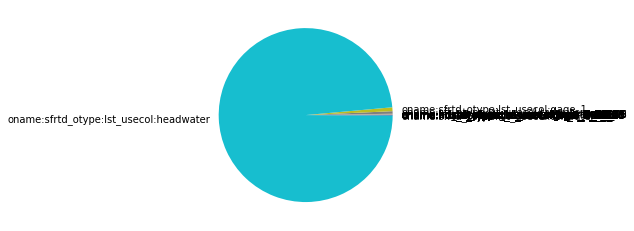

In [11]:
phicomp = pd.Series(pst.phi_components)

plt.pie(phicomp, labels=phicomp.index.values);

Try displaying this with `pyemu.plot_utils.res_phi_pie()` instead. Because of the large number of columns it's not going to be pretty, but it gets the job done.

In [12]:
# pyemu.plot_utils.res_phi_pie(pst,);

So that's a bit disturbing. Phi is almost entirely dominated by a single observation group!

If we were to history match with these weights, PEST would prioritize achieveing a good fit with observations of that group. This could mean other observations are ignored. Worse, we might end up with worse fits with other observations in PEST's quest to improve fits with the dominant obsveration group. And, well, if we have gone to the trouble of including these observations in our history matching dataset they must include some usefull information. Why would we throw that out?


### 4. Weighting for Visibility

As discussed above, a practical means of accommodating this situation is to weight all observation groups
such that they contribute an equal amount to the starting measurement objective function. In this
manner, no single group dominates the objective function, or is dominated by others; the information
contained in each group is therefore equally “visible” to PEST.

The `Pst.adjust_weights()` method provides a mechanism to fine tune observation weights according to their contribution to the objective function. (*Side note: the PWTADJ1 utility from the PEST-suite automates this same process of "weighting for visibility".*) 

We start by creating a dictionary of non-zero weighted observation group names and their respective contributions to the objective function. We will specify that we want each group to contribute a value of 100 to the objective function. (Why 100? No particular reason. Could just as easily be 1000. Or 578. Doesn't really matter. 100 is a nice round number though.)

In [13]:
# create a dictionary of group names and weights
balanced_groups = {grp:100 for grp in pst.nnz_obs_groups}
balanced_groups

{'oname:hds_otype:lst_usecol:trgw_0_13_10': 100,
 'oname:hds_otype:lst_usecol:trgw_0_15_16': 100,
 'oname:hds_otype:lst_usecol:trgw_0_21_10': 100,
 'oname:hds_otype:lst_usecol:trgw_0_22_15': 100,
 'oname:hds_otype:lst_usecol:trgw_0_24_4': 100,
 'oname:hds_otype:lst_usecol:trgw_0_26_6': 100,
 'oname:hds_otype:lst_usecol:trgw_0_29_15': 100,
 'oname:hds_otype:lst_usecol:trgw_0_2_15': 100,
 'oname:hds_otype:lst_usecol:trgw_0_2_9': 100,
 'oname:hds_otype:lst_usecol:trgw_0_33_7': 100,
 'oname:hds_otype:lst_usecol:trgw_0_34_10': 100,
 'oname:hds_otype:lst_usecol:trgw_0_3_8': 100,
 'oname:hds_otype:lst_usecol:trgw_0_9_1': 100,
 'oname:hds_otype:lst_usecol:trgw_2_13_10': 100,
 'oname:hds_otype:lst_usecol:trgw_2_15_16': 100,
 'oname:hds_otype:lst_usecol:trgw_2_21_10': 100,
 'oname:hds_otype:lst_usecol:trgw_2_22_15': 100,
 'oname:hds_otype:lst_usecol:trgw_2_24_4': 100,
 'oname:hds_otype:lst_usecol:trgw_2_26_6': 100,
 'oname:hds_otype:lst_usecol:trgw_2_29_15': 100,
 'oname:hds_otype:lst_usecol:trg

We can now use the `pst.adjust_weights()` method to adjust the observation weights in the `pst` control file object. (*Remember! This all only happnes in memory. It does not get written to the PEST control file file!*)

In [14]:
# make all non-zero weighted groups have a contribution of 100.0
pst.adjust_weights(obsgrp_dict=balanced_groups,)

If we now plot the phi components again, voila! We have a nice even distribution of phi from each observation group.

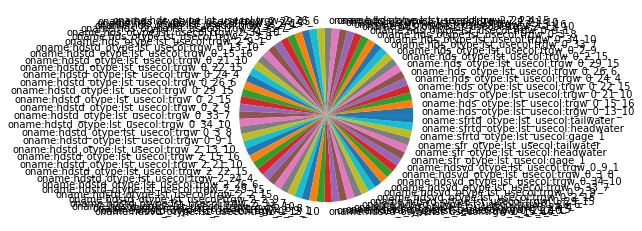

In [15]:
phicomp = pd.Series(pst.phi_components)
plt.pie(phicomp, labels=phicomp.index.values);

Make sure to write the updated pest control file:


In [16]:
pst.write(os.path.join(t_d, 'freyberg_wv.pst')) # we are using the "_wv" sufix to indicate Weighted for Visibility

noptmax:0, npar_adj:25429, nnz_obs:920


### 5. Understanding Observation Weights and Measurement Noise

There is a common source of confusion: observation weights for history matching *versus* observation weights for generating an observation ensemble in `pestpp-ies`. 

 - when **history-matching**, observation weights listed in the control file determine their contribution to the objective function, and therefore to the parameter estimation process. Here, observation weights may be assigned to reflect observation uncertainty, the balance required for equal "visibility", or other modeller-defined (and perhaps subjective...) measures of observation worth.  
 - when **generating an observation ensemble**, weights should reflect the inverse of the standard deviation of measurement noise. However, unless instructed otherwise, `pestpp-ies` will generate an observation ensemble *using observation weights in the PEST control file*. Therefore, when history-matching with `pestpp-ies` and using weights that **do not** reflect observation uncertainty, it is important to provide `pestpp-ies` with a previously prepared observation ensemble.

Our observation weights no longer reflect measurement noise. So, when we use `pestpp-ies` later on, we are going to have to explicitly provide an observation ensemble. 

Here, we will now visualize what different weighting schemes actually imply when generating an observation ensemble.


Let's start off by visualizing what weights actually imply. The function in the next cell does a bunch of funky things in order to plot observation time series (convenient that we stored all the necessary information in observation names, hey?). 

In [17]:
def plot_obs_ts(pst, oe, obsgrps=pst.nnz_obs_groups):
    # get times and "measured values"
    nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
    nz_obs['time'] = nz_obs['time'].astype(float)
    nz_obs.sort_values(['obgnme','time'], inplace=True)
    
    # to plot crrent model outputs
    res = pst.res.copy()
    res['time'] = pst.observation_data['time'].astype(float)
    res.sort_values(['group','time'], inplace=True)

    for nz_group in obsgrps:
        nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
        nz_obs_meas = res.loc[(res['group']==nz_group) & res['weight']!=0]

        fig,ax = plt.subplots(1,1,figsize=(10,2))
        
        [ax.plot(nz_obs_group.time, oe.loc[r,nz_obs_group.obsnme] ,color="r",lw=0.3) for r in oe.index]
        ax.plot(nz_obs_group.time,nz_obs_group.obsval,"b")
        #ax.plot(nz_obs_meas.time, nz_obs_meas.modelled, 'k', linestyle='--')
        ax.set_title(nz_group)
    plt.show()
    return


Let's start with the "weighting for visibility" weights wich we have just specified:


In [18]:
oe = pyemu.ObservationEnsemble.from_gaussian_draw(pst=pst, 
                                                num_reals=5) # the number of realisations; usualy would be more here we just use a few for demo purposes

Let's visualize the time series of observations for the SFR measurment types. Run the next cell.

The blue line is the te series of "field measured" values (in the control file). The red lines are time series from the observation ensemble. What we are saying with these weights is that any of these red lines culd also have been "measured". Due to the noise (e.g. uncertainty) in our measurements, the true value can fall any where ni that range.

Do they look right to you? In particular, take a look at the "sfrtd" observation grpups (the plots at the bottom). The uncertianty range is alot larger than the others...that's odd isn't it? We said that uncertainty of "differences" between observations tends to be smaller... 

Well this is because the weights here do not reflect mearument uncertainty. They should **not** be used to generate observation ensembles as they do not reflect measurement noise...

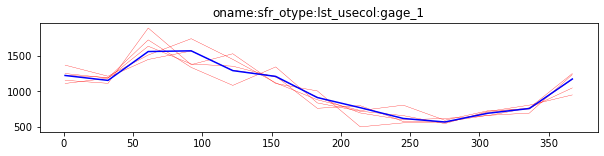

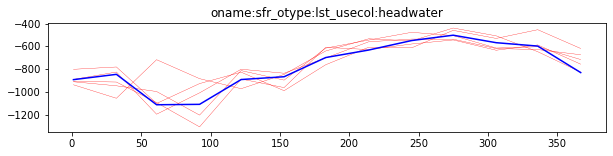

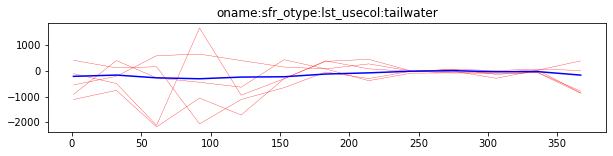

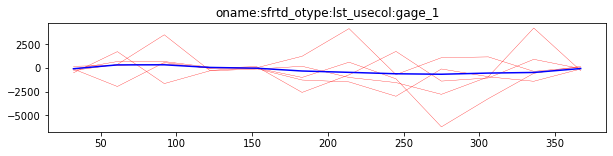

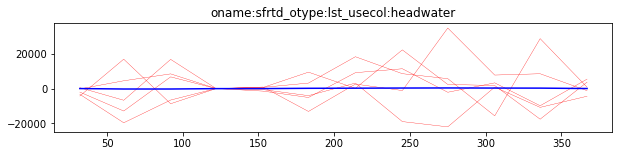

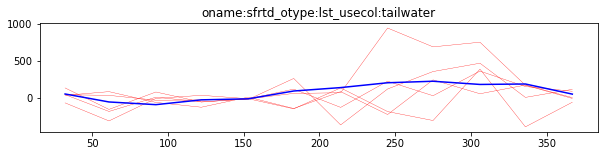

In [19]:
sfr_ts_obs = [i for i in pst.nnz_obs_groups if 'sfr' in i]

plot_obs_ts(pst, oe, sfr_ts_obs)

Let's try that again. But ths time, let's use the correct weights. Recall from the "freyberg pstfrom pest setup" notebook that we made a point of recording two observation uncertainty covariance matrices. We can use these to inform our observation ensemble (convenient huh?).

In [20]:
# load a Cov object from the covraiance matrix assuming no observation uncertantiny autocorrleation
obs_cov_diag = pyemu.Cov.from_binary(os.path.join(t_d,'obs_cov_diag.jcb' ))

# generate an ensemble using the Cov
oe2 = pyemu.ObservationEnsemble.from_gaussian_draw(pst=pst, cov=obs_cov_diag, 
                                                num_reals=5) # the number of realisations; usualy would be more here we just use a few for demo purposes

drawing from group oname:hds_otype:lst_usecol:trgw_0_13_10
drawing from group oname:hds_otype:lst_usecol:trgw_0_15_16
drawing from group oname:hds_otype:lst_usecol:trgw_0_21_10
drawing from group oname:hds_otype:lst_usecol:trgw_0_22_15
drawing from group oname:hds_otype:lst_usecol:trgw_0_24_4
drawing from group oname:hds_otype:lst_usecol:trgw_0_26_6
drawing from group oname:hds_otype:lst_usecol:trgw_0_29_15
drawing from group oname:hds_otype:lst_usecol:trgw_0_2_15
drawing from group oname:hds_otype:lst_usecol:trgw_0_2_9
drawing from group oname:hds_otype:lst_usecol:trgw_0_33_7
drawing from group oname:hds_otype:lst_usecol:trgw_0_34_10
drawing from group oname:hds_otype:lst_usecol:trgw_0_3_8
drawing from group oname:hds_otype:lst_usecol:trgw_0_9_1
drawing from group oname:hds_otype:lst_usecol:trgw_2_13_10
drawing from group oname:hds_otype:lst_usecol:trgw_2_15_16
drawing from group oname:hds_otype:lst_usecol:trgw_2_21_10
drawing from group oname:hds_otype:lst_usecol:trgw_2_22_15
drawing

And now if we plot this ensemble...there we go, that cloud of spaghetti lines for the "difference" observations are nice and tight, reflecting our greater confidence in the accuracy of these "observed" values.

Take a look at the first two plots (time series of the absolute SFR flux values). They don't look too bad, hey? Although...the red lines do still jump around quite a bit...looks a bit like white noise. Good thing we generated a covarince matrix that accounts for autocorrelated transient noise, hey? (see the "freyberg pstfrom pest setup" notebook).

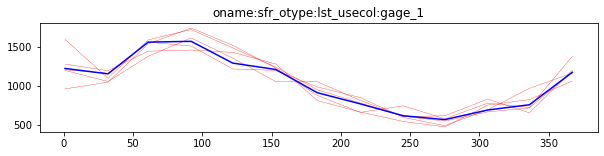

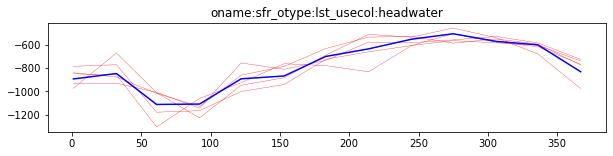

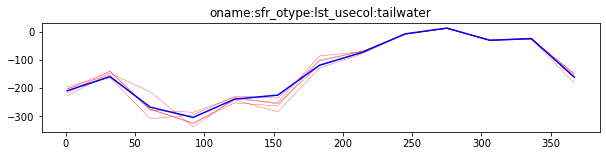

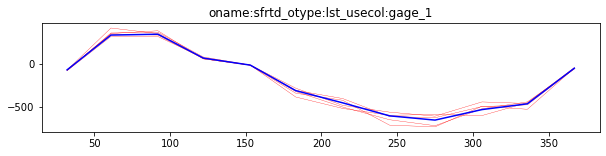

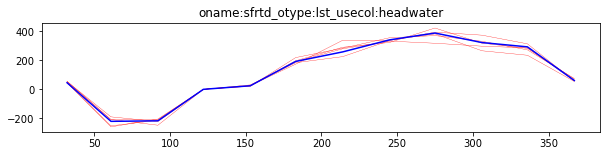

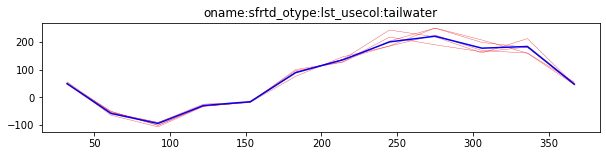

In [21]:
plot_obs_ts(pst, oe2, sfr_ts_obs)

Let's try that one last time!

In [22]:
# load a Cov object from the covraiance matrix assuming there is observation uncertantiny autocorrleation
obs_cov = pyemu.Cov.from_binary(os.path.join(t_d,'obs_cov.jcb' ))

# generate an ensemble using the Cov
oe3 = pyemu.ObservationEnsemble.from_gaussian_draw(pst=pst, cov=obs_cov, 
                                                num_reals=5) # the number of realisations; usualy would be more here we just use a few for demo purposes

drawing from group oname:hds_otype:lst_usecol:trgw_0_13_10
drawing from group oname:hds_otype:lst_usecol:trgw_0_15_16
drawing from group oname:hds_otype:lst_usecol:trgw_0_21_10
drawing from group oname:hds_otype:lst_usecol:trgw_0_22_15
drawing from group oname:hds_otype:lst_usecol:trgw_0_24_4
drawing from group oname:hds_otype:lst_usecol:trgw_0_26_6
drawing from group oname:hds_otype:lst_usecol:trgw_0_29_15
drawing from group oname:hds_otype:lst_usecol:trgw_0_2_15
drawing from group oname:hds_otype:lst_usecol:trgw_0_2_9
drawing from group oname:hds_otype:lst_usecol:trgw_0_33_7
drawing from group oname:hds_otype:lst_usecol:trgw_0_34_10
drawing from group oname:hds_otype:lst_usecol:trgw_0_3_8
drawing from group oname:hds_otype:lst_usecol:trgw_0_9_1
drawing from group oname:hds_otype:lst_usecol:trgw_2_13_10
drawing from group oname:hds_otype:lst_usecol:trgw_2_15_16
drawing from group oname:hds_otype:lst_usecol:trgw_2_21_10
drawing from group oname:hds_otype:lst_usecol:trgw_2_22_15
drawing

As you can see, now the red lines are a bit less erratic, reflecting the correlation we have specified for noise in observations that were measured cloaser together (in time). 

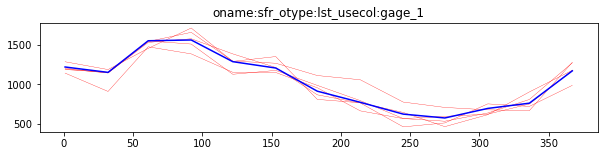

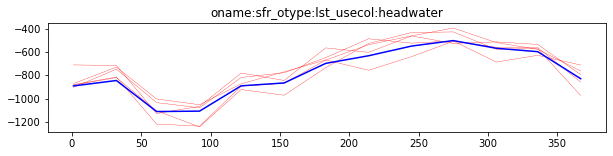

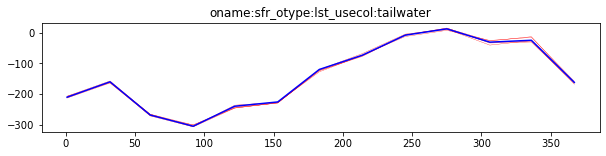

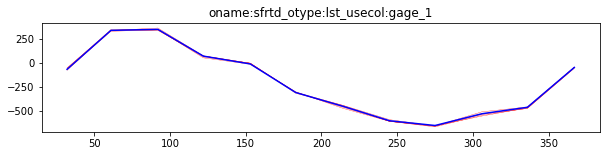

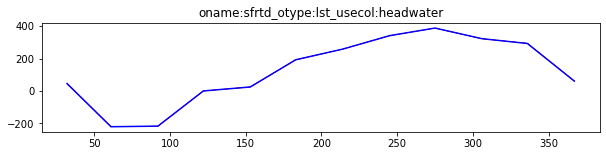

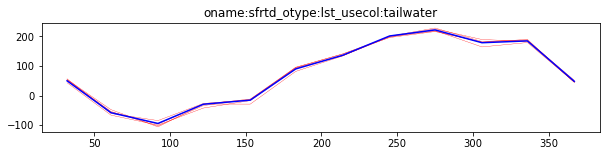

In [23]:
plot_obs_ts(pst, oe3, sfr_ts_obs)